In [40]:
import numpy as np
import pandas as pd

import tifffile as tiff
import zarr

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from matplotlib.widgets import PolygonSelector
from matplotlib.path import Path

plt.style.use('dark_background')

In [41]:
# Define file paths.
DIRNAME = '/Volumes/HITS/lsp-data/cycif-techdev/Dan_Mitosis_20250409'

MARKER_PATH = f'{DIRNAME}/mcmicro/LSP19912/markers.csv'
CELL_PATH = f'{DIRNAME}/mcmicro/LSP19912/quantification/LSP19912--unmicst_nucleiRing.csv'

IF_PATH = f'{DIRNAME}/LSP19912.ome.tif'
HE_PATH = f'{DIRNAME}/HE_VS200/ImageLSP19912-registered.ome.tif'

ROW_PATH = f'{DIRNAME}/vae_data_32px_best/row_idx.npy'
SUBSET_PATH = f'{DIRNAME}/vae_data_32px_best/subset_idx.npy'
VALID_PATH = f'{DIRNAME}/vae_data_32px_best/valid_idx.npy'
CH_PATH = f'{DIRNAME}/vae_data_32px_best/ch_idx.npy'

LOSS_PATH = f'{DIRNAME}/vae_data_32px_best/loss.csv'
EMB_PATH = f'{DIRNAME}/vae_data_32px_best/embedding.csv'

THUMBNAIL_PATH = f'{DIRNAME}/vae_data_32px/thumbnails.npy'
DECODE_PATH = f'{DIRNAME}/vae_data_32px_best/thumbnails_valid_recon.npy'

In [42]:
# Import marker table.
markers = pd.read_csv(MARKER_PATH, usecols=['marker_name'], index_col='marker_name')
markers.index = markers.index.to_series().replace({'Hoechst1': ['Hoechst1_1', 'Hoechst1_2']}) # temporary fix
markers['img_index'] = range(len(markers)) # indices relative to original image

# Subset channels.
ch_idx = np.load(CH_PATH)
markers['tmb_index'] = -1
markers.iloc[ch_idx, -1] = range(len(ch_idx)) # indices relative to train thumbnails

# Print marker table.
markers

img_index  tmb_index
marker_name                      
Hoechst1_1           0         -1
A488                 1          0
A555                 2          1
A647                 3          2
Hoechst2             4          3
PCNA                 5         -1
pH3                  6         -1
Tubulin              7          4
Ki67                 8         -1
Hoechst3             9         -1
gTUB                10          5
pAUR1/2/3           11         -1
AcetylTUB           12          6
SOX10               13         -1
Hoechst1_2          14         -1
LaminA/C            15          7
pRB                 16         -1
gH2ax               17         -1
LaminB              18          8

In [43]:
# Predefine marker colors.
colors = {
    'A488': 'white',
    'A555': 'white',
    'A647': 'white',    
    'Ki67': 'yellow',
    'pRB': 'yellow',
    'PCNA': 'yellow',
    'pAUR1/2/3': 'magenta',
    'pH3': 'red',
    'gH2ax': 'red',
    'LaminA/C': 'yellow',
    'LaminB': 'yellow',
    'Tubulin': 'magenta',
    'AcetylTUB': 'magenta',
    'gTUB': 'white',
    'SOX10': 'lime'
}
markers['color'] = 'cyan'
markers.loc[colors.keys(), 'color'] = list(colors.values())
markers['alpha'] = 1

### Evaluate model

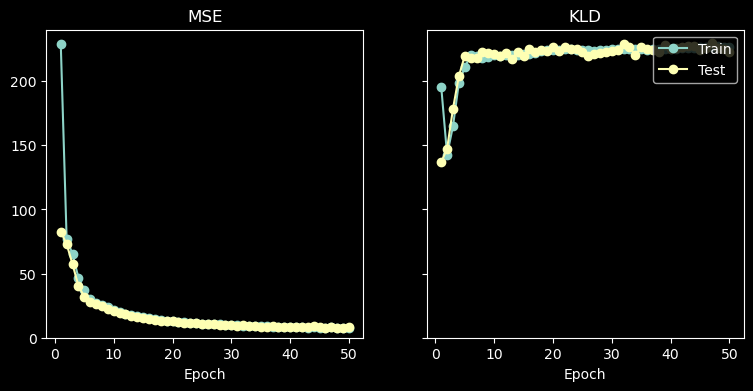

In [44]:
# Import loss.
loss = pd.read_csv(LOSS_PATH)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

# Plot MSE loss.
ax1.plot(loss['epoch'], loss['train_mse_loss'], 'o-')
ax1.plot(loss['epoch'], loss['valid_mse_loss'], 'o-')
ax1.set_title('MSE')
ax1.set_xlabel('Epoch')
ax1.set_ylim(bottom=0)

# Plot KLD loss.
ax2.plot(loss['epoch'], loss['train_kld_loss'], 'o-')
ax2.plot(loss['epoch'], loss['valid_kld_loss'], 'o-')
ax2.set_title('KLD')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Test'], loc='upper right')

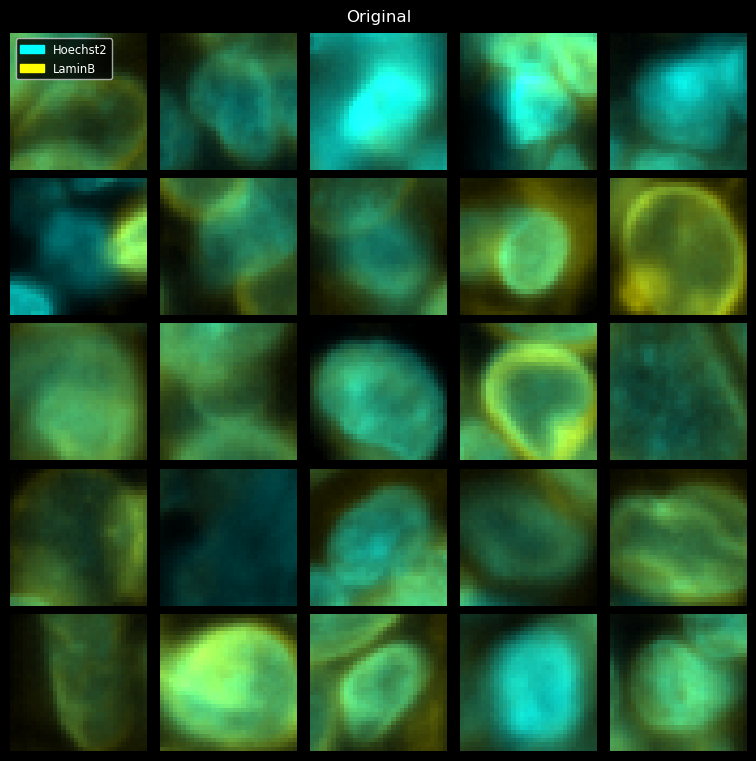

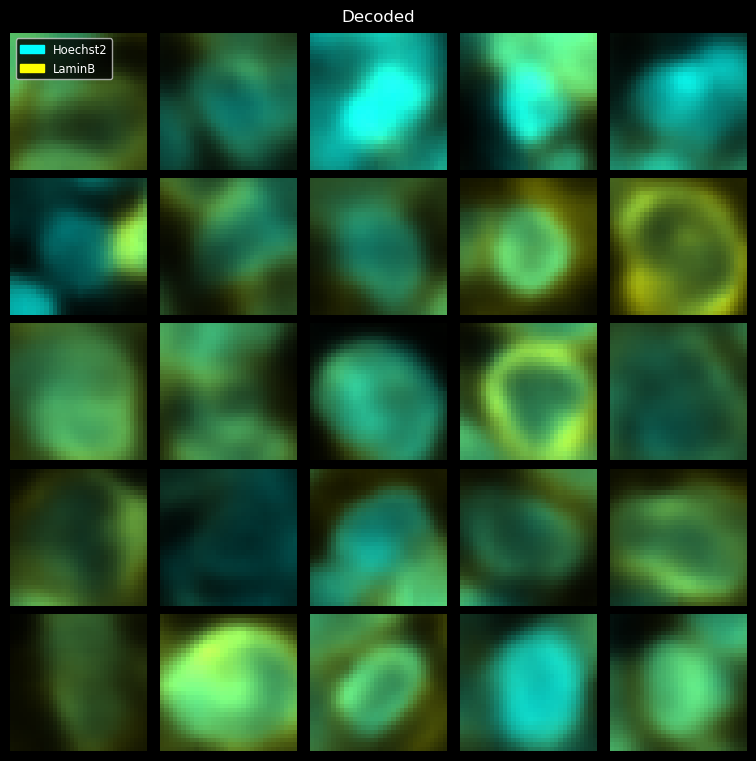

In [70]:
VALID_PATH = f'{DIRNAME}/vae_data_32px/train_subset_idx.npy' # temp
DECODE_PATH = f'{DIRNAME}/vae_data_32px/thumbnails_train_recon.npy' # temp

# Import thumbnails.
thumbnails = np.load(THUMBNAIL_PATH, mmap_mode='r')
decoded = np.load(DECODE_PATH, mmap_mode='r')

# Subset test thumbnails.
valid_idx = np.load(VALID_PATH)
sample_idx = np.random.choice(len(valid_idx), 25, replace=False)
valid_thumbnails = thumbnails[valid_idx[sample_idx]]
valid_thumbnails = valid_thumbnails[:, [3, 8], ...] # temp
valid_decoded = decoded[sample_idx]

# Function to merge IF channels into RGB image.
def merge_channels(x, channels):
    overlay = np.zeros((*x.shape[:-1], 3), dtype=float)
    for i, (color, alpha) in enumerate(channels):
        rgb_vec = np.array(to_rgb(color))
        rgb = x[..., i, None] * rgb_vec * alpha
        overlay += rgb
    return overlay.clip(0, 1)

# Subset channels.
TO_PLOT = ['Hoechst2', 'LaminB']
ch_idx, ch_col, ch_alpha = markers.loc[TO_PLOT, ['tmb_index', 'color', 'alpha']].T.values
ch_idx = np.array([0, 1]) # temp

# Plot original and decoded thumbnails.
for title, dataset in (('Original', valid_thumbnails), ('Decoded', valid_decoded)):
    fig, axs = plt.subplots(5, 5, figsize=(7.5, 7.5), constrained_layout=True)
    for i, ax in enumerate(axs.flat):
        x = dataset[i, ch_idx.tolist(), ...].transpose(1, 2, 0)
        x = merge_channels(x, zip(ch_col, ch_alpha))
        ax.imshow(x)
        ax.axis('off')
    fig.suptitle(title)
    add_legend(axs[0, 0], TO_PLOT)

### Explore embedding

In [46]:
# Import cell table.
row_idx = np.load(ROW_PATH)
subset_idx = np.load(SUBSET_PATH)
col_names = markers.index.to_list() + ['X_centroid', 'Y_centroid']
cells = pd.read_csv(CELL_PATH, usecols=col_names)
cells = cells.iloc[row_idx].iloc[subset_idx].reset_index(drop=True)
cells[['X_centroid', 'Y_centroid']] = cells[['X_centroid', 'Y_centroid']].astype(int)

# Transform marker expression.
markers[['qmin', 'qmax']] = 0.
for m in markers.index:
    bounds = np.quantile(cells[m], (0.02, 0.9999))
    markers.loc[m, ['qmin', 'qmax']] = bounds
    cells[m] = np.clip(cells[m], *bounds)
    cells[m] = np.log1p(cells[m])

In [47]:
# Import UMAP embedding.
emb = pd.read_csv(EMB_PATH, usecols=['UMAP1', 'UMAP2'])
cells[emb.columns] = emb

Text(0, 0.5, 'UMAP2')

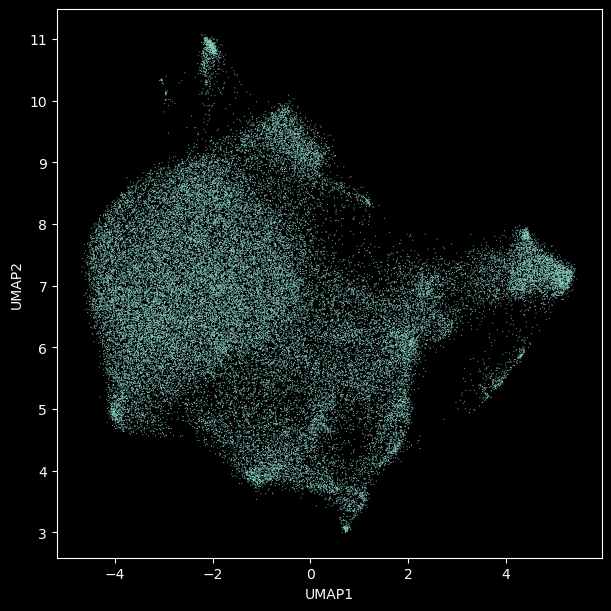

In [48]:
# Plot UMAP.
plt.figure(figsize=(6, 6), constrained_layout=True)
plt.scatter(cells['UMAP1'], cells['UMAP2'], s=0.5, edgecolors='none')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

/var/folders/_s/t09jv3217zv1z325cjmq4npc0000gq/T/ipykernel_25142/344953579.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(title=MARKER, frameon=False)


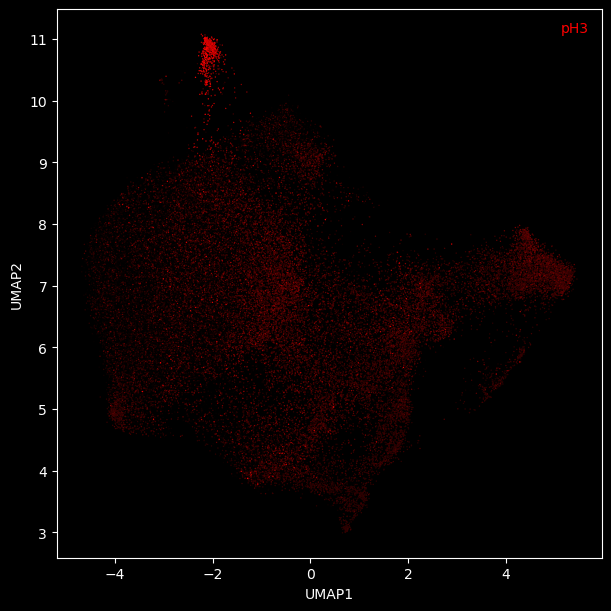

In [49]:
# Define color scale.
MARKER = 'pH3'
col = markers.loc[MARKER, 'color']
cmap = LinearSegmentedColormap.from_list('if', ['black', col])

# Overlay marker expression.
plt.figure(figsize=(6, 6), constrained_layout=True)
plt.scatter(cells['UMAP1'], cells['UMAP2'], s=1, c=cells[MARKER], cmap=cmap, edgecolors='none')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Add color legend.
legend = plt.legend(title=MARKER, frameon=False)
legend.get_title().set_color(col)

In [52]:
%matplotlib qt

# Plot interactive UMAP.
cells_subset = cells.sample(20_000)
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.scatter(cells_subset['UMAP1'], cells_subset['UMAP2'], s=1, edgecolors='none')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Function to select cells.
def onselect(verts):
    path = Path(verts)
    cells['selected'] = path.contains_points(cells[['UMAP1', 'UMAP2']])
    print(f'Selected {np.sum(cells['selected'])} cells.')

# Create polygon selector.
selector = PolygonSelector(ax, onselect)
selector.set_props(color='white')

Selected 619 cells.


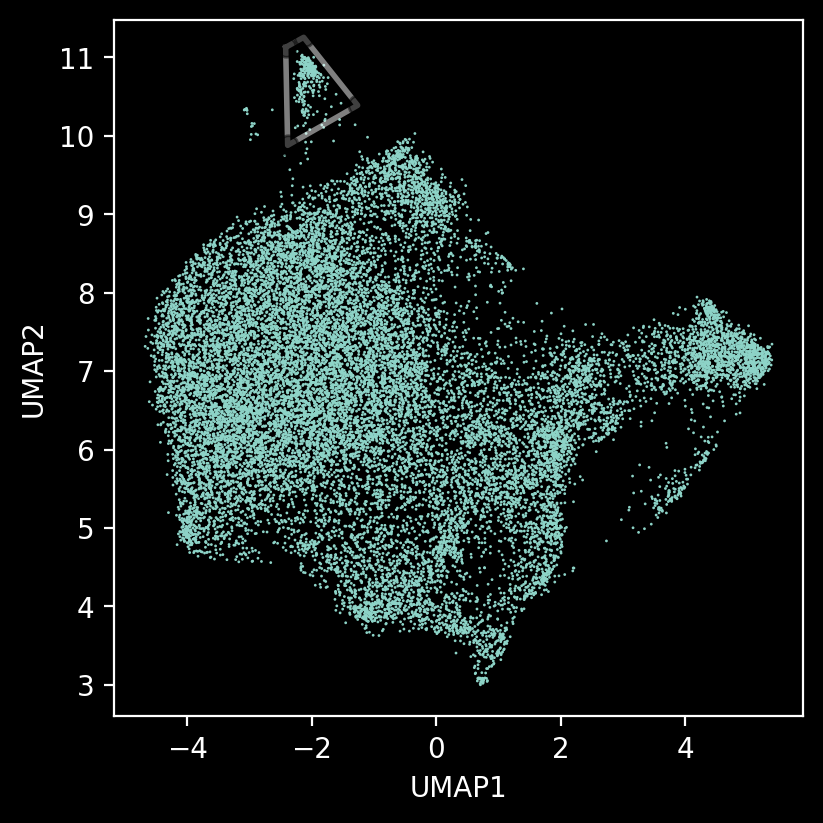

In [53]:
# Close selector.
%matplotlib inline
plt.show()

In [54]:
# Load IF image.
if_store = tiff.imread(IF_PATH, aszarr=True)
if_img = zarr.open(if_store)[0]

# Load H&E image.
he_store = tiff.imread(HE_PATH, aszarr=True)
he_img = zarr.open(he_store)[0]

In [55]:
# Function to crop patch around a centroid.
def crop_cell(img, xcenter, ycenter, ch=slice(None), window=100):
    offset = window // 2
    xstart, xend = xcenter - offset, xcenter + offset
    ystart, yend = ycenter - offset, ycenter + offset
    return img[ch, ystart:yend, xstart:xend]

# Function to process IF patch.
def plot_if(img, markers, xcenter, ycenter, channels):
    idx, col, alpha = markers.loc[channels, ['img_index', 'color', 'alpha']].T.values
    qmin, qmax = np.log1p(markers.loc[channels, ['qmin', 'qmax']]).T.values
    x = np.stack([crop_cell(img, xcenter, ycenter, i) for i in idx], axis=-1) # YXC
    x = np.log1p(x)
    x = (x - qmin) / (qmax - qmin)
    x = x.clip(0, 1)
    return merge_channels(x, zip(col, alpha))

# Function to create a centered bounding box.
def center_box(img_size, box_size):
    start = (img_size - box_size) // 2
    return Rectangle(xy=(start, start), width=box_size, height=box_size,
                     edgecolor='white', facecolor='none', linewidth=2, 
                     linestyle='--', alpha=0.5)

# Function to create a legend.
def add_legend(ax, channels):
    colors = markers.loc[channels, 'color']
    patches = [Rectangle((0, 0), 1, 1, color=to_rgb(c)) for c in colors]
    ax.legend(patches, channels, loc='upper left', frameon=True, fontsize='small')

In [56]:
# Subset cells to plot.
select_subset = cells[cells['selected']].sample(25, replace=False)
select_subset = select_subset[['X_centroid', 'Y_centroid']].to_numpy()

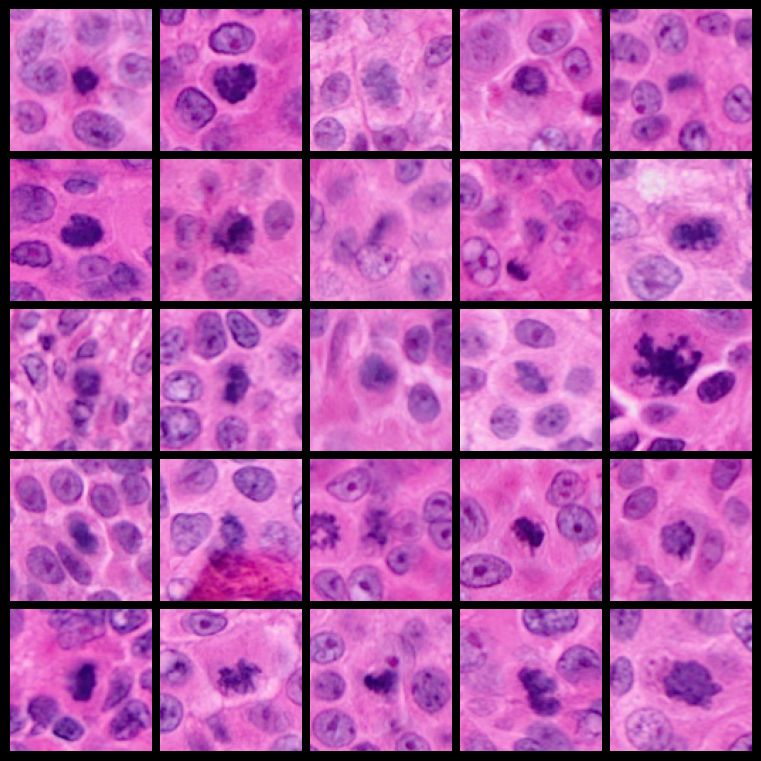

In [57]:
# Plot H&E cells.
_, axs = plt.subplots(5, 5, figsize=(7.5, 7.5), constrained_layout=True)
for ax, (xcenter, ycenter) in zip(axs.flat, select_subset):
    x = crop_cell(he_img, xcenter, ycenter)
    ax.imshow(x.transpose(1, 2, 0))
    # box = center_box(100, 32)
    # ax.add_patch(box)
    ax.axis('off')

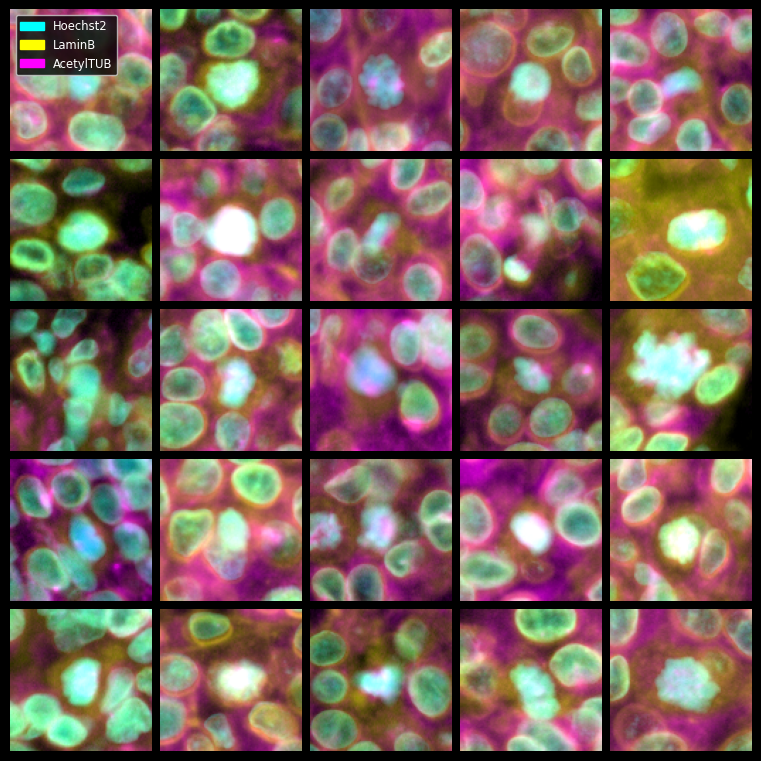

In [74]:
# Plot IF cells.
markers["alpha"] = 0.8 # temp
TO_PLOT = ['Hoechst2', 'LaminB', 'AcetylTUB']
_, axs = plt.subplots(5, 5, figsize=(7.5, 7.5), constrained_layout=True)
for ax, (xcenter, ycenter) in zip(axs.flat, select_subset):
    x = plot_if(if_img, markers, xcenter, ycenter, TO_PLOT)
    ax.imshow(x)
    # box = center_box(100, 32)
    # ax.add_patch(box)
    ax.axis('off')
add_legend(axs[0, 0], TO_PLOT)

(-0.5, 1548.5, 1360.5, -0.5)

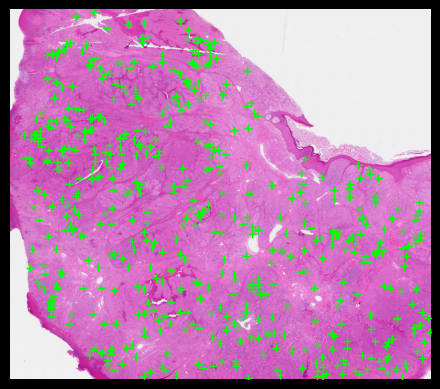

In [59]:
# Downsample H&E image.
downsample = 5
he_thumb = zarr.open(he_store)[downsample][:]

# Downample cell coordinates.
cells_selected = cells.loc[cells['selected'], ['X_centroid', 'Y_centroid']]
cells_selected /= (2 ** downsample)

# Plot cell locations.
plt.imshow(he_thumb.transpose(1, 2, 0))
plt.scatter(cells_selected.X_centroid, cells_selected.Y_centroid, marker='+', c='lime', linewidth=1)
plt.axis('off')